In [82]:
import os, time
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
%matplotlib inline

from IPython.display import display, HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [83]:
# Create timestamp to show when this summary was run
print 'Summary run: ' + time.strftime("%a, %d %b %Y %H:%M")

Summary run: Tue, 04 Aug 2020 12:27


In [84]:
base_path = os.getcwd().split('\\scripts')[0]
relative_path = '../../../outputs'
pd.options.display.float_format = '{:,.3f}'.format
format_percent = "{:,.2%}".format

# Workers by County

In [85]:
df_wfh = pd.read_csv(os.path.join(relative_path,'agg','dash','wfh_county.csv'))
df_wfh_survey = pd.read_csv(os.path.join(relative_path,'agg','dash','survey','wfh_county.csv'))

# Total Workers by County
df_tot = pd.read_csv(os.path.join(relative_path,'agg','dash','pptyp_county.csv'))
df_tot = df_tot[df_tot['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df_tot = df_tot.groupby('person_county').sum()[['psexpfac']].reset_index()
total_nonwfh_workers = df_tot.sum()['psexpfac']

df_tot_survey = pd.read_csv(os.path.join(relative_path,'agg','dash','survey','pptyp_county.csv'))
df_tot_survey = df_tot_survey[df_tot_survey['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df_tot_survey = df_tot_survey.groupby('person_county').sum()[['psexpfac']].reset_index()
total_nonwfh_workers_survey = df_tot_survey.sum()['psexpfac']

df = df_wfh.merge(df_tot, on='person_county')
df.index = df['person_county']
df.drop('person_county', axis=1,inplace=True)
df.columns = ['WFH Workers', 'Total Workers']
df.loc['Region'] = df.sum(axis=0)
df['% WFH Workers'] = df['WFH Workers']/df['Total Workers']
df

,WFH Workers,Total Workers,% WFH Workers
person_county,,,
King,36343,757936,0.048
Kitsap,6431,185105,0.035
Pierce,18085,466723,0.039
Snohomish,15840,469048,0.034
Region,76699,1878812,0.041


In [86]:
df_tot.sum()['psexpfac']

1878812

# Tour Rate for Work-at-Home Workers

In [87]:
df_tours = pd.read_csv(os.path.join(relative_path,'agg','dash','work_from_home_tours.csv'))
total_wfh_workers = df_wfh.psexpfac.sum()
df = df_tours.groupby('pdpurp').sum()[['toexpfac']].reset_index()
df['tour_rate'] = df['toexpfac']/total_wfh_workers
df

df_tours_survey = pd.read_csv(os.path.join(relative_path,'agg','dash','survey','work_from_home_tours.csv'))
total_wfh_workers_survey = df_wfh.psexpfac.sum()
df_survey = df_tours_survey.groupby('pdpurp').sum()[['toexpfac']].reset_index()
df_survey['tour_rate'] = df_survey['toexpfac']/total_wfh_workers_survey
df = df.merge(df_survey,on='pdpurp',suffixes=['_model','_survey'])
df.rename(columns={'toexpfac_model': 'tours_model', 'toexpfac_survey': 'tours_survey'}, inplace=True)
df['tours_survey'] = df['tours_survey'].astype('int')
df[['pdpurp','tours_model','tours_survey','tour_rate_model','tour_rate_survey']]

,pdpurp,tours_model,tours_survey,tour_rate_model,tour_rate_survey
0,Escort,27487,23855,0.358,0.311
1,Meal,3838,13909,0.050,0.181
2,Personal Business,18970,37415,0.247,0.488
3,School,2275,675,0.030,0.009
4,Shop,23359,51951,0.305,0.677
5,Social,23146,76870,0.302,1.002
6,Work,11494,25577,0.150,0.333


### Tour Rates for Workers that do NOT WF

In [88]:
# Tour Rates by purpose by worker type
df = pd.read_csv(os.path.join(relative_path,'agg','dash','non_wfh_tours.csv'))
df = df[df['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df = df.groupby('pdpurp').sum().reset_index()
df['tour_rate'] = df['toexpfac']/df_tot.sum()[['psexpfac']].values[0]

df_survey = pd.read_csv(os.path.join(relative_path,'agg','dash','survey','non_wfh_tours.csv'))
df_survey = df_survey[df_survey['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df_survey = df_survey.groupby('pdpurp').sum().reset_index()
df_survey['tour_rate'] = df_survey['toexpfac']/df_tot_survey.sum()[['psexpfac']].values[0]

df = df.merge(df_survey, on='pdpurp', suffixes=['_model','_survey'])
df.rename(columns={'toexpfac_model':'total_tours_model','toexpfac_survey':'total_tours_survey'},
         inplace=True)
df[['pdpurp','total_tours_model','total_tours_survey','tour_rate_model','tour_rate_survey']]

,pdpurp,total_tours_model,total_tours_survey,tour_rate_model,tour_rate_survey
0,Escort,216992,"173,138.190",0.115,0.091
1,Meal,351263,"233,295.070",0.187,0.123
2,Personal Business,182624,"265,388.630",0.097,0.140
3,School,27289,"15,916.400",0.015,0.008
4,Shop,244233,"247,085.710",0.130,0.131
5,Social,493263,"442,733.820",0.263,0.234
6,Work,1673836,"1,870,382.830",0.891,0.988


In [89]:
total_nonwfh_workers

1878812

### Tour Rates for Non-Workers

In [90]:
df = pd.read_csv(os.path.join(relative_path,'agg','dash','non_wfh_tours.csv'))
df = df[-df['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df = df.groupby('pdpurp').sum().reset_index()
df['tour_rate'] = df['toexpfac']/df_tot_survey.sum()[['psexpfac']].values[0]


df_survey = pd.read_csv(os.path.join(relative_path,'agg','dash','survey','non_wfh_tours.csv'))
df_survey = df_survey[-df_survey['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df_survey = df_survey.groupby('pdpurp').sum().reset_index()
df_survey['tour_rate'] = df_survey['toexpfac']/df_tot_survey.sum()[['psexpfac']].values[0]

df = df.merge(df_survey, on='pdpurp', suffixes=['_model','_survey'])
df.rename(columns={'toexpfac_model':'total_tours_model','toexpfac_survey':'total_tours_survey'},
         inplace=True)
df[['pdpurp','total_tours_model','total_tours_survey','tour_rate_model','tour_rate_survey']]

,pdpurp,total_tours_model,total_tours_survey,tour_rate_model,tour_rate_survey
0,Escort,492346,"422,966.420",0.260,0.223
1,Meal,129205,"163,207.570",0.068,0.086
2,Personal Business,529495,"599,422.640",0.280,0.317
3,School,663579,"699,217.240",0.351,0.369
4,Shop,506647,"491,168.590",0.268,0.260
5,Social,739683,"739,493.790",0.391,0.391
6,Work,89680,"130,935.260",0.047,0.069


# Commute Tour Distance
All Workers

In [91]:
df = pd.read_csv(os.path.join(relative_path,'agg','dash','tour_distance.csv'))
df = df[df['pdpurp'] == 'Work']

pd.options.display.float_format = '{:0,.4f}'.format
_df = df.groupby('tautodist_bin').sum()[['toexpfac']].reset_index()

_df['percent'] = _df['toexpfac']/_df['toexpfac'].sum()
_df['cumulative_percent'] = _df['percent'].cumsum()

# remove records that are outside 99% of records
_df = _df[_df['cumulative_percent'] <= 0.99]

In [92]:
df_survey = pd.read_csv(os.path.join(relative_path,'agg','dash','survey','tour_distance.csv'))
df_survey = df_survey[df_survey['pdpurp'] == 'Work']

_df_survey = df_survey.groupby('tautodist_bin').sum()[['toexpfac']].reset_index()

_df_survey['percent'] = _df_survey['toexpfac']/_df_survey['toexpfac'].sum()
_df_survey['cumulative_percent'] = _df_survey['percent'].cumsum()

# remove records that are outside 99% of records
_df_survey = _df_survey[_df_survey['cumulative_percent'] <= 0.99]

Weighted Average Distance

In [93]:
_df_merged = _df.merge(_df_survey, on='tautodist_bin', suffixes=['_model','_survey'])
print('model: '+ str((_df_merged['toexpfac_model']*_df_merged['tautodist_bin']).sum()*1.0/_df_merged['toexpfac_model'].sum()))
print('survey: '+ str((_df_merged['toexpfac_survey']*_df_merged['tautodist_bin']).sum()*1.0/_df_merged['toexpfac_survey'].sum()))

model: 10.1361423145
survey: 10.4238467037


In [94]:
# Work trip distance to not usual workplace for non-WFH workers


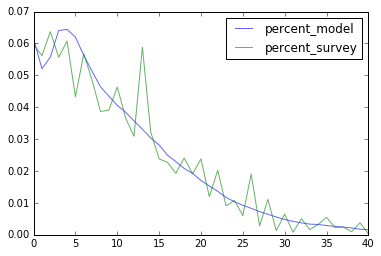

In [95]:
_df_merged[['percent_model','percent_survey']].plot(alpha=0.6)

# _df[['trexpfac']].plot(kind='bar')

# Average Trip Distance
Workers that work DO NOT work from home

In [96]:
# Non WFH Workers
df = pd.read_csv(os.path.join(relative_path,'agg','dash','trip_distance_non_wfh.csv'))
df = df[df['pptyp'].isin(['Full-Time Worker','Part-Time Worker'])]
df = df[(df['dpurp'] == 'Work') & (df['dadtyp'].isin(['Other','Usual Workplace']))]
# df.groupby(['travdist_bin','']).sum()[['trexpfac']]
df_usual = df[df['dadtyp'] == 'Usual Workplace']
dist = (df_usual['trexpfac']*1.0*df_usual['travdist_bin']).sum()/df_usual['trexpfac'].sum()
print('Avg. distance to Usual Workplace: ' + str(dist))
df_other = df[df['dadtyp'] == 'Other']
dist = (df_other['trexpfac']*1.0*df_other['travdist_bin']).sum()/df_other['trexpfac'].sum()
print('Avg. distance to Other Workplace: ' + str(dist))
print('----------------------------------------')
# Non WFH Workers
df = pd.read_csv(os.path.join(relative_path,'agg','dash','trip_distance_non_wfh.csv'))
df['wt_sum'] = df['trexpfac']*1.0*df['travdist_bin']
result = {}
for purp in pd.unique(df['dpurp']):
    _df = df[df['dpurp'] == purp]
    result[purp] = _df['wt_sum'].sum()/_df['trexpfac'].sum()
    
_df_non_wfh = pd.DataFrame.from_dict(result, orient='index').reset_index()
_df_non_wfh.columns = ['Purpose','Workers at Non-Home Location']
_df_non_wfh

Avg. distance to Usual Workplace: 8.3549228016
Avg. distance to Other Workplace: 4.66798346721
----------------------------------------


,Purpose,Workers at Non-Home Location
0,Shop,3.6451
1,School,3.0783
2,Work,7.5863
3,Meal,2.7314
4,Change Mode Inserted Purpose,7.9345
5,Escort,5.2214
6,Social,3.8378
7,None/Home,5.3121
8,Personal Business,4.4043


Only workers that work **from home**

In [97]:
# WFH Workers
df = pd.read_csv(os.path.join(relative_path,'agg','dash','trip_distance_wfh.csv'))
df = df[(df['dpurp'] == 'Work') & (df['dadtyp'].isin(['Other','Usual Workplace']))]

df_other = df[df['dadtyp'] == 'Other']
dist = (df_other['trexpfac']*1.0*df_other['travdist_bin']).sum()/df_other['trexpfac'].sum()
print('Avg. distance to Other Workplace: ' + str(dist))
print('----------------------------------')
df = pd.read_csv(os.path.join(relative_path,'agg','dash','trip_distance_wfh.csv'))
df['wt_sum'] = df['trexpfac']*1.0*df['travdist_bin']
result = {}
for purp in pd.unique(df['dpurp']):
    _df = df[df['dpurp'] == purp]
    result[purp] = _df['wt_sum'].sum()/_df['trexpfac'].sum()

_df_wfh = pd.DataFrame.from_dict(result, orient='index')
_df_wfh = _df_wfh.reset_index()
_df_wfh.columns = ['Purpose','WFH Workers']
_df_wfh

Avg. distance to Other Workplace: 4.30608661725
----------------------------------


,Purpose,WFH Workers
0,Shop,1.9539
1,School,4.6230
2,Work,4.3024
3,Meal,1.8106
4,Change Mode Inserted Purpose,4.7218
5,Escort,2.4720
6,Social,1.9846
7,None/Home,2.5749
8,Personal Business,1.9663


In [98]:
# Non-Workers
df = pd.read_csv(os.path.join(relative_path,'agg','dash','trip_distance_non_wfh.csv'))
df = df[-df['pptyp'].isin(['Full-Time Worker','Part-Time Worker'])]
df = df[(df['dpurp'] == 'Work') & (df['dadtyp'].isin(['Other','Usual Workplace']))]

# Non-Workers
df = pd.read_csv(os.path.join(relative_path,'agg','dash','trip_distance_non_wfh.csv'))
df['wt_sum'] = df['trexpfac']*1.0*df['travdist_bin']
result = {}
for purp in pd.unique(df['dpurp']):
    _df = df[df['dpurp'] == purp]
    result[purp] = _df['wt_sum'].sum()/_df['trexpfac'].sum()
    
_df_non_worker = pd.DataFrame.from_dict(result, orient='index')
_df_non_worker = _df_non_worker.reset_index()
_df_non_worker.columns = ['Purpose','Non-Workers']
_df_non_worker

,Purpose,Non-Workers
0,Shop,3.6451
1,School,3.0783
2,Work,7.5863
3,Meal,2.7314
4,Change Mode Inserted Purpose,7.9345
5,Escort,5.2214
6,Social,3.8378
7,None/Home,5.3121
8,Personal Business,4.4043


Average Trip Distance by Purpose and Worker/Person Type

In [99]:
_df = pd.merge(_df_non_wfh, _df_wfh).merge(_df_non_worker)

In [100]:
_df

,Purpose,Workers at Non-Home Location,WFH Workers,Non-Workers
0,Shop,3.6451,1.9539,3.6451
1,School,3.0783,4.6230,3.0783
2,Work,7.5863,4.3024,7.5863
3,Meal,2.7314,1.8106,2.7314
4,Change Mode Inserted Purpose,7.9345,4.7218,7.9345
5,Escort,5.2214,2.4720,5.2214
6,Social,3.8378,1.9846,3.8378
7,None/Home,5.3121,2.5749,5.3121
8,Personal Business,4.4043,1.9663,4.4043


# VMT

Workers that Work from Home

In [101]:
df = pd.read_csv(os.path.join(relative_path,'agg','dash','vmt_wfh.csv'))
df_survey = pd.read_csv(os.path.join(relative_path,'agg','dash','survey','vmt_wfh.csv'))

pd.options.display.float_format = '{:,.2f}'.format
_df = df[(df['mode'].isin(['SOV','HOV2','HOV3+']))&
   (df['dorp']==1) &
   (df['pptyp'].isin(['Full-Time Worker','Part-Time Worker']))].groupby('dpurp').sum()[['travdist_wt']]
_df['VMT per Person (Model)'] = _df['travdist_wt']/total_wfh_workers

_df_survey = df_survey[(df_survey['mode'].isin(['SOV','HOV2','HOV3+']))&
   (df_survey['dorp']==1) &
   (df_survey['pptyp'].isin(['Full-Time Worker','Part-Time Worker']))].groupby('dpurp').sum()[['travdist_wt']]
_df_survey['VMT per Person (Model)'] = _df_survey['travdist_wt']/total_wfh_workers_survey

_df = _df.merge(_df_survey, left_index=True, right_index=True, suffixes=['_model','_survey'])
_df.loc['Total',:] = _df.sum()
_df[['travdist_wt_model','travdist_wt_survey']] = _df[['travdist_wt_model','travdist_wt_survey']].astype('int')
_df.rename(columns={'travdist_wt_model': 'Total VMT (Model)', 'travidst_wt_survey': 'Total VMT (Survey)'},
                   inplace=True)
_df

,Total VMT (Model),VMT per Person (Model)_model,travdist_wt_survey,VMT per Person (Model)_survey
dpurp,,,,
Change Mode Inserted Purpose,126,0.00,22100,0.29
Escort,76959,1.00,125808,1.64
Meal,12899,0.17,31104,0.41
None/Home,212353,2.77,328871,4.29
Personal Business,71882,0.94,45008,0.59
School,2357,0.03,421,0.01
Shop,81255,1.06,215302,2.81
Social,47951,0.63,140911,1.84
Work,6871,0.09,33978,0.44


Workers that do NOT Work from Home

In [102]:
df = pd.read_csv(os.path.join(relative_path,'agg','dash','vmt_nonwfh.csv'))
df_survey = pd.read_csv(os.path.join(relative_path,'agg','dash','survey','vmt_nonwfh.csv'))

pd.options.display.float_format = '{:,.2f}'.format
_df = df[(df['mode'].isin(['SOV','HOV2','HOV3+']))&
   (df['dorp']==1) &
   (df['pptyp'].isin(['Full-Time Worker','Part-Time Worker']))].groupby('dpurp').sum()[['travdist_wt']]
_df['VMT per Person (Model)'] = _df['travdist_wt']/total_nonwfh_workers

_df_survey = df_survey[(df_survey['mode'].isin(['SOV','HOV2','HOV3+']))&
   (df_survey['dorp']==1) &
   (df_survey['pptyp'].isin(['Full-Time Worker','Part-Time Worker']))].groupby('dpurp').sum()[['travdist_wt']]
_df_survey['VMT per Person (Model)'] = _df_survey['travdist_wt']/total_nonwfh_workers_survey

_df = _df.merge(_df_survey, left_index=True, right_index=True, suffixes=['_model','_survey'])
_df.loc['Total',:] = _df.sum()
_df[['travdist_wt_model','travdist_wt_survey']] = _df[['travdist_wt_model','travdist_wt_survey']].astype('int')
_df.rename(columns={'travdist_wt_model': 'Total VMT (Model)', 'travidst_wt_survey': 'Total VMT (Survey)'},
                   inplace=True)
_df

,Total VMT (Model),VMT per Person (Model)_model,travdist_wt_survey,VMT per Person (Model)_survey
dpurp,,,,
Change Mode Inserted Purpose,264018,0.14,82025,0.04
Escort,2763094,1.47,3229390,1.71
Meal,1281522,0.68,1920011,1.01
None/Home,16314454,8.68,17445260,9.22
Personal Business,2043437,1.09,3088130,1.63
School,191260,0.10,72220,0.04
Shop,2356817,1.25,3888156,2.05
Social,2432931,1.29,3188491,1.68
Work,16807966,8.95,20806319,10.99


# Commute Tour Distance by Mode
All Workers

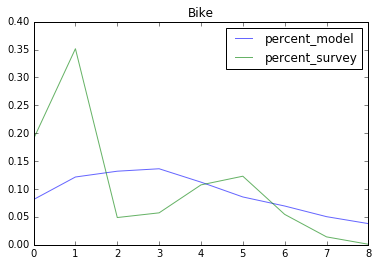

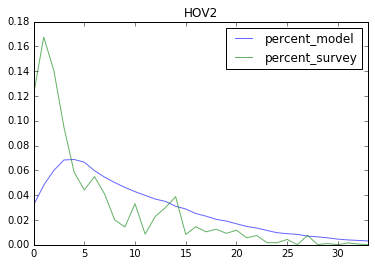

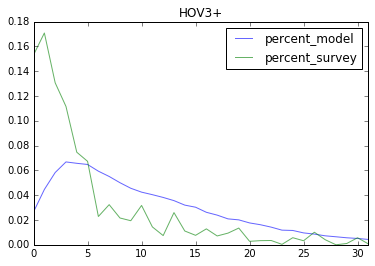

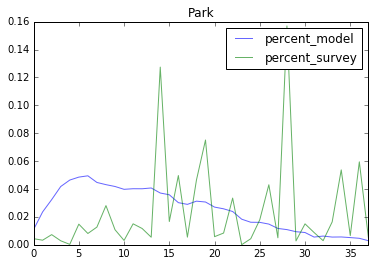

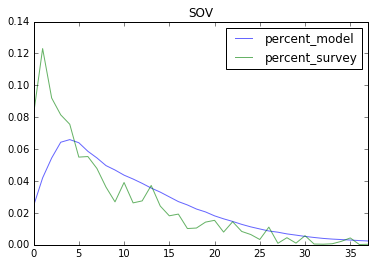

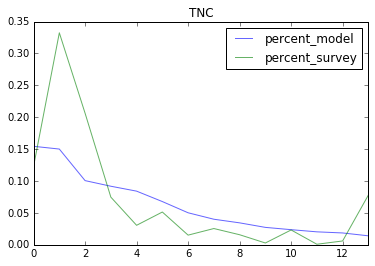

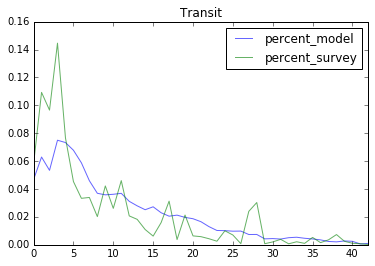

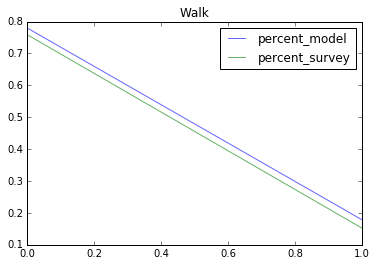

In [106]:
df = pd.read_csv(os.path.join(relative_path,'agg','dash','tour_distance.csv'))
df_survey = pd.read_csv(os.path.join(relative_path,'agg','dash','survey','tour_distance.csv'))
df = df[df['pdpurp'] == 'Work']
df = df[df['tmodetp'] != "-1"]

for mode in df['tmodetp'].unique():
    _df = df[df['tmodetp'] == mode]
    
    _df = _df.groupby('tautodist_bin').sum()[['toexpfac']].reset_index()

    _df['percent'] = _df['toexpfac']/_df['toexpfac'].sum()
    _df['cumulative_percent'] = _df['percent'].cumsum()

    # remove records that are outside 99% of records
    _df = _df[_df['cumulative_percent'] <= 0.99]
    
    _df_survey = df_survey[df_survey['tmodetp'] == mode]
    _df_survey = _df_survey.groupby('tautodist_bin').sum()[['toexpfac']].reset_index()

    _df_survey['percent'] = _df_survey['toexpfac']/_df_survey['toexpfac'].sum()
    _df_survey['cumulative_percent'] = _df_survey['percent'].cumsum()

    # remove records that are outside 99% of records
    _df_survey = _df_survey[_df_survey['cumulative_percent'] <= 0.99]
    
    _df_merged = _df.merge(_df_survey, on='tautodist_bin', suffixes=['_model','_survey'])
    _df_merged[['percent_model','percent_survey']].plot(alpha=0.6, title=mode)
    